# Home Court Advantage Analysis

In this Notebook, we will conduct analysis on whether home court advantage exists in the NBA. We will use the `team_statistics.csv` dataset to analyze the statistics of home and away games.

<b> For this purpose, we have asked us the following questions: </b>
- Does the home team win more often than the away team?
- Do the referees call fewer fouls on the home team (i.e. the home team gets more free throws than the away team)?
- If the home team wins, does it win by a larger margin than if the away team wins?
- Does the home team score on a higher percentage (FG%, FT%, 3P%) than the away team?

## Setup

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import yaml
from IPython.display import Markdown, display

In [84]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [83]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

In [85]:
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics.csv"))
team_statistics_df.info()
team_statistics_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91649 entries, 0 to 91648
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   91649 non-null  int64  
 1   gameDate                 91649 non-null  object 
 2   teamCity                 91649 non-null  object 
 3   teamName                 91649 non-null  object 
 4   teamId                   91649 non-null  int64  
 5   opponentTeamCity         91649 non-null  object 
 6   opponentTeamName         91649 non-null  object 
 7   opponentTeamId           91649 non-null  int64  
 8   home                     91649 non-null  int64  
 9   win                      91649 non-null  int64  
 10  teamScore                91649 non-null  int64  
 11  opponentScore            91649 non-null  int64  
 12  assists                  91645 non-null  float64
 13  blocks                   91632 non-null  float64
 14  steals                

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,biggestScoringRun,leadChanges,pointsFastBreak,pointsFromTurnovers,pointsInThePaint,pointsSecondChance,timesTied,timeoutsRemaining,seasonWins,seasonLosses
0,22401058,2025-03-26 22:00:00,Boston,Celtics,1610612738,Phoenix,Suns,1610612756,0,1,...,15.0,0.0,9.0,16.0,44.0,17.0,0.0,1.0,54.0,19.0
1,22401058,2025-03-26 22:00:00,Phoenix,Suns,1610612756,Boston,Celtics,1610612738,1,0,...,10.0,0.0,9.0,7.0,36.0,16.0,0.0,1.0,35.0,38.0
2,22401057,2025-03-26 21:00:00,Denver,Nuggets,1610612743,Milwaukee,Bucks,1610612749,1,1,...,9.0,2.0,20.0,18.0,64.0,16.0,4.0,1.0,46.0,28.0
3,22401057,2025-03-26 21:00:00,Milwaukee,Bucks,1610612749,Denver,Nuggets,1610612743,0,0,...,7.0,2.0,5.0,17.0,56.0,13.0,4.0,0.0,40.0,32.0
4,22401054,2025-03-26 19:30:00,Brooklyn,Nets,1610612751,Toronto,Raptors,1610612761,1,0,...,8.0,0.0,12.0,7.0,46.0,12.0,1.0,1.0,23.0,50.0


Since we want to analyze home court advantage, we need a dataset for both only home and only away games

In [86]:
drop_columns = ["gameDate", "teamCity", "teamName", "teamId", "opponentTeamCity", "opponentTeamName", "opponentTeamId"]
home_court_advantage_df = team_statistics_df.drop(columns=drop_columns)

home_statistics_df = home_court_advantage_df[home_court_advantage_df["home"] == True]
away_statistics_df = home_court_advantage_df[home_court_advantage_df["home"] == False]
home_court_advantage_df.head()

# Only select rows where the gameId exists in both home and away games
home_statistics_df = home_statistics_df[home_statistics_df["gameId"].isin(away_statistics_df["gameId"])]
away_statistics_df = away_statistics_df[away_statistics_df["gameId"].isin(home_statistics_df["gameId"])]
home_court_advantage_df = home_court_advantage_df[home_court_advantage_df["gameId"].isin(home_statistics_df["gameId"])]
home_statistics_df.drop(columns=["gameId", "home"], inplace=True)
away_statistics_df.drop(columns=["gameId", "home"], inplace=True)
home_statistics_df.reset_index(drop=True, inplace=True)
away_statistics_df.reset_index(drop=True, inplace=True)

<ipython-input-86-83d66cb85d91>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_statistics_df.drop(columns=["gameId", "home"], inplace=True)


First, we perform Summary Statstics on the home and away statistics.

In [87]:
# Summary Statistics:
home_statistics_df.describe()

,win,teamScore,opponentScore,assists,blocks,steals,fieldGoalsAttempted,fieldGoalsMade,fieldGoalsPercentage,threePointersAttempted,...,biggestScoringRun,leadChanges,pointsFastBreak,pointsFromTurnovers,pointsInThePaint,pointsSecondChance,timesTied,timeoutsRemaining,seasonWins,seasonLosses
count,45542.000000,45542.000000,45542.000000,45540.000000,45534.000000,45427.000000,45542.000000,45542.000000,45542.000000,45542.000000,...,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000
mean,0.599776,104.387994,101.185455,23.958103,5.301709,7.962247,84.011264,39.160204,0.466902,18.728097,...,10.204651,6.716279,15.656744,17.476279,49.175814,14.287442,4.840930,0.467907,18.230698,18.307907
std,0.489949,13.738733,13.494477,5.570885,2.757361,3.083661,8.408252,5.840579,0.058000,10.926975,...,2.691627,6.058257,6.719876,6.852812,10.042080,5.837191,4.125341,0.499201,12.401747,12.489067
min,0.000000,49.000000,53.000000,5.000000,0.000000,0.000000,53.000000,18.000000,0.234000,1.000000,...,5.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,95.000000,92.000000,20.000000,3.000000,6.000000,78.000000,35.000000,0.427000,10.000000,...,8.000000,2.000000,11.000000,13.000000,42.000000,10.000000,2.000000,0.000000,8.000000,8.000000
50%,1.000000,104.000000,101.000000,24.000000,5.000000,8.000000,84.000000,39.000000,0.466000,17.000000,...,10.000000,5.000000,15.000000,17.000000,48.000000,14.000000,4.000000,0.000000,17.000000,17.000000
75%,1.000000,113.000000,110.000000,28.000000,7.000000,10.000000,89.000000,43.000000,0.506000,26.000000,...,12.000000,10.000000,20.000000,22.000000,56.000000,18.000000,7.000000,1.000000,27.000000,27.000000
max,1.000000,175.000000,176.000000,51.000000,23.000000,27.000000,130.000000,68.000000,0.697000,70.000000,...,24.000000,42.000000,46.000000,45.000000,88.000000,36.000000,22.000000,1.000000,58.000000,57.000000


In [88]:
away_statistics_df.describe()

,win,teamScore,opponentScore,assists,blocks,steals,fieldGoalsAttempted,fieldGoalsMade,fieldGoalsPercentage,threePointersAttempted,...,biggestScoringRun,leadChanges,pointsFastBreak,pointsFromTurnovers,pointsInThePaint,pointsSecondChance,timesTied,timeoutsRemaining,seasonWins,seasonLosses
count,45542.000000,45542.000000,45542.000000,45540.000000,45535.000000,45427.000000,45542.000000,45542.000000,45542.000000,45542.000000,...,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000
mean,0.400224,101.185455,104.387994,22.259047,4.699528,7.836529,83.843178,38.082188,0.455020,18.725023,...,10.102326,6.716279,15.316279,17.573953,48.703256,13.969302,4.840930,0.436279,18.235349,18.253023
std,0.489949,13.494477,13.738733,5.345806,2.505350,3.001973,8.447080,5.641289,0.056438,10.816746,...,2.658521,6.058257,6.505152,6.567574,10.740044,5.571107,4.125341,0.496154,12.674828,12.507472
min,0.000000,53.000000,49.000000,4.000000,0.000000,0.000000,55.000000,16.000000,0.239000,1.000000,...,5.000000,0.000000,0.000000,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,92.000000,95.000000,19.000000,3.000000,6.000000,78.000000,34.000000,0.417000,10.000000,...,8.000000,2.000000,10.000000,13.000000,42.000000,10.000000,2.000000,0.000000,7.500000,8.000000
50%,0.000000,101.000000,104.000000,22.000000,4.000000,8.000000,84.000000,38.000000,0.455000,17.000000,...,10.000000,5.000000,15.000000,17.000000,48.000000,13.000000,4.000000,0.000000,16.000000,17.000000
75%,1.000000,110.000000,113.000000,26.000000,6.000000,10.000000,89.000000,42.000000,0.494000,26.000000,...,11.500000,10.000000,19.000000,22.000000,56.000000,18.000000,7.000000,1.000000,26.000000,27.000000
max,1.000000,176.000000,175.000000,52.000000,19.000000,24.000000,129.000000,68.000000,0.687000,63.000000,...,23.000000,42.000000,39.000000,40.000000,84.000000,33.000000,22.000000,1.000000,60.000000,56.000000


In [89]:
home_win_percentage = home_statistics_df["win"].mean()
away_win_percentage = away_statistics_df["win"].mean()
home_margin = home_statistics_df["plusMinusPoints"]
away_margin = away_statistics_df["plusMinusPoints"]

display(Markdown(f"**Home Team Win Percentage:** {home_win_percentage}"))
display(Markdown(f"**Away Team Win Percentage:** {away_win_percentage}"))
display(Markdown(f"**Home Team Margin of Victory:** {home_margin.mean()}"))
display(Markdown(f"**Away Team Margin of Victory:** {away_margin.mean()}"))

**Home Team Win Percentage:** 0.5997760309165167

**Away Team Win Percentage:** 0.4002239690834834

**Home Team Margin of Victory:** 3.3055537182794277

**Away Team Margin of Victory:** -3.0172738763110627

From the summary statistics we can already observe a few key points:
- The home team does win with a higher percentage than the away team.
- The home team does have better statistics in all categories, though we cannot conclude yet if it is significant.

Next up, we will create some plots:

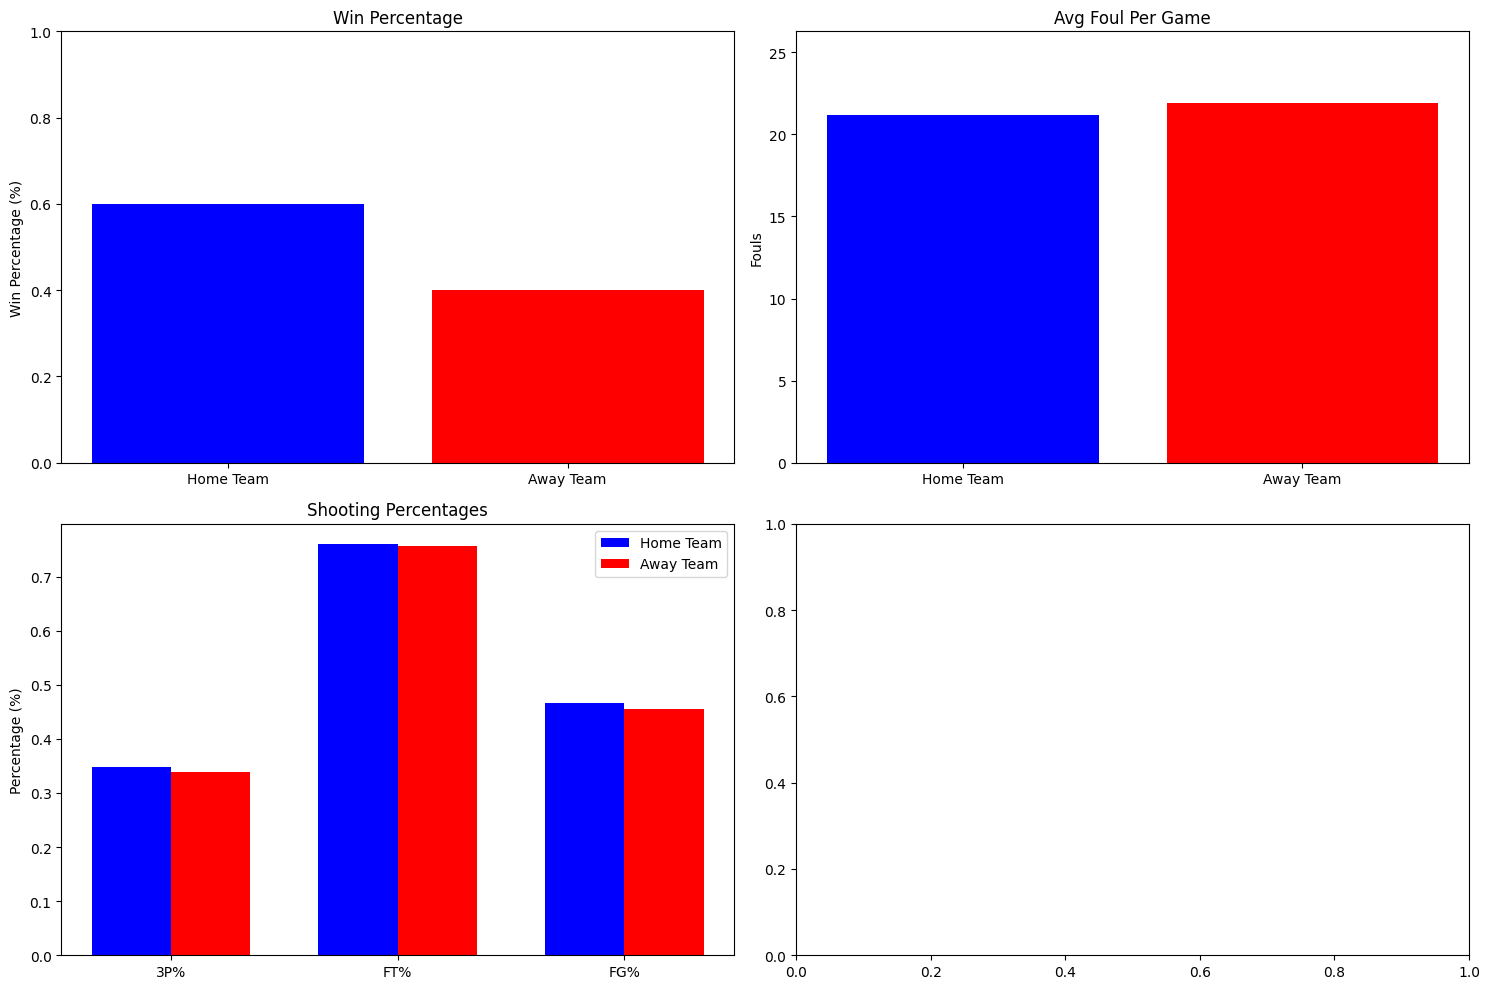

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Win Percentage Plot
axs[0].bar(["Home Team", "Away Team"], [home_win_percentage, away_win_percentage], color=["blue", "red"])
axs[0].set_title("Win Percentage")
axs[0].set_ylabel("Win Percentage (%)")
axs[0].set_ylim(0, 1)

# Foul Calls Plot
foul_home_mean = home_statistics_df["foulsPersonal"].mean()
foul_away_mean = away_statistics_df["foulsPersonal"].mean()
axs[1].bar(["Home Team", "Away Team"], [foul_home_mean, foul_away_mean], color=["blue", "red"])
axs[1].set_title("Avg Foul Per Game")
axs[1].set_ylabel("Fouls")
axs[1].set_ylim(0, max(foul_home_mean, foul_away_mean) * 1.2)

# Percentages Plots
three_home = home_statistics_df["threePointersPercentage"].mean()
three_away = away_statistics_df["threePointersPercentage"].mean()
fg_home = home_statistics_df["fieldGoalsPercentage"].mean()
fg_away = away_statistics_df["fieldGoalsPercentage"].mean()
ft_home = home_statistics_df["freeThrowsPercentage"].mean()
ft_away = away_statistics_df["freeThrowsPercentage"].mean()

categories = ["3P%", "FT%", "FG%"]
home_values = [three_home, ft_home, fg_home]
away_values = [three_away, ft_away, fg_away]
x = np.arange(len(categories))
width = 0.35

axs[2].bar(x - width/2, home_values, width, label='Home Team', color='blue')
axs[2].bar(x + width/2, away_values, width, label='Away Team', color='red')
axs[2].set_title("Shooting Percentages")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categories)
axs[2].set_ylabel("Percentage (%)")
axs[2].legend()

plt.tight_layout()
plt.show()

We do see, that on average, the home team does win more often, and has better statistics in all categories. However, we need to check if this is statistically significant.

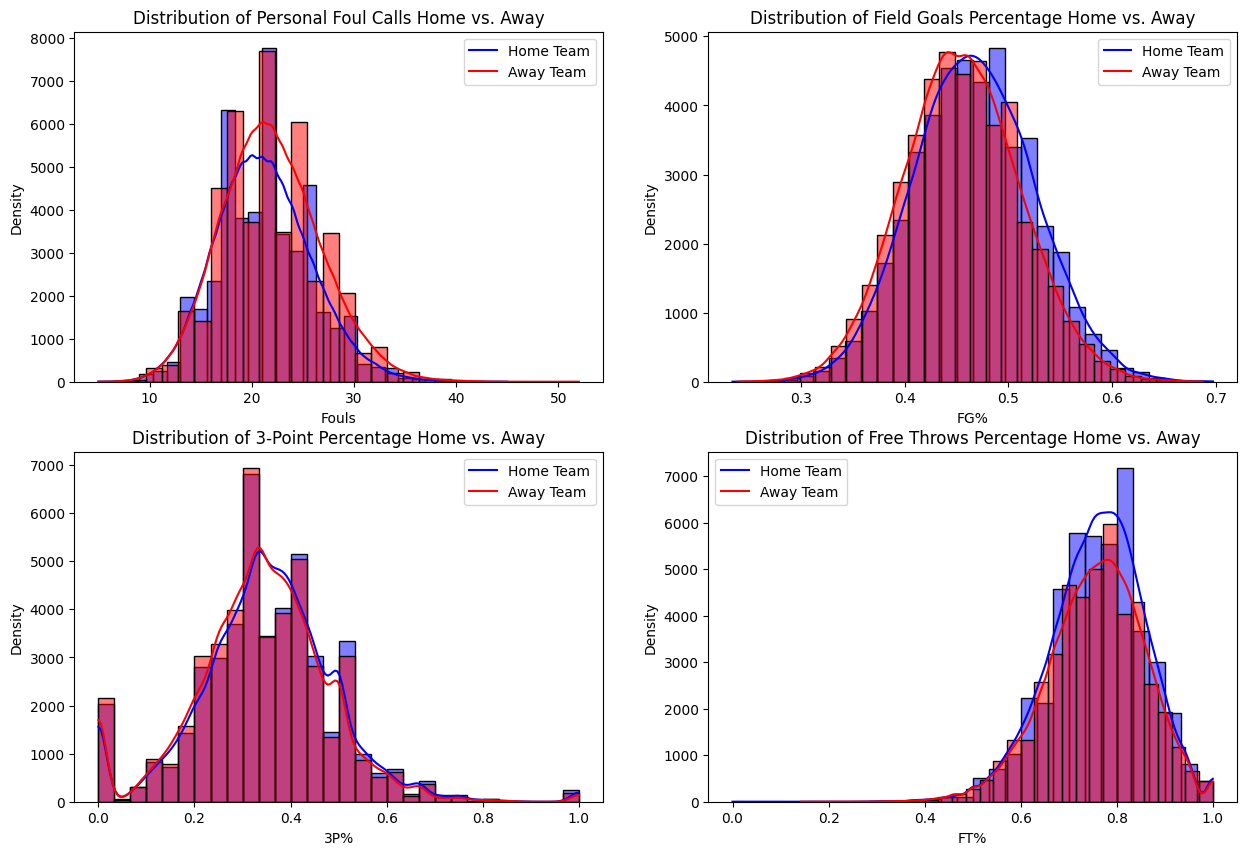

In [91]:
# Plot distributions
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Foul Calls
sns.histplot(home_statistics_df["foulsPersonal"], bins=30, kde=True, color="blue", ax=axs[0])
sns.histplot(away_statistics_df["foulsPersonal"], bins=30, kde=True, color="red", ax=axs[0])
axs[0].set_title("Distribution of Personal Foul Calls Home vs. Away")
axs[0].set_xlabel("Fouls")
axs[0].set_ylabel("Density")
axs[0].legend(["Home Team", "Away Team"])

# FG%
sns.histplot(home_statistics_df["fieldGoalsPercentage"], bins=30, kde=True, color="blue", ax=axs[1])
sns.histplot(away_statistics_df["fieldGoalsPercentage"], bins=30, kde=True, color="red", ax=axs[1])
axs[1].set_title("Distribution of Field Goals Percentage Home vs. Away")
axs[1].set_xlabel("FG%")
axs[1].set_ylabel("Density")
axs[1].legend(["Home Team", "Away Team"])
# 3P%
sns.histplot(home_statistics_df["threePointersPercentage"], bins=30, kde=True, color="blue", ax=axs[2])
sns.histplot(away_statistics_df["threePointersPercentage"], bins=30, kde=True, color="red", ax=axs[2])
axs[2].set_title("Distribution of 3-Point Percentage Home vs. Away")
axs[2].set_xlabel("3P%")
axs[2].set_ylabel("Density")
axs[2].legend(["Home Team", "Away Team"])
# FT%
sns.histplot(home_statistics_df["freeThrowsPercentage"], bins=30, kde=True, color="blue", ax=axs[3])
sns.histplot(away_statistics_df["freeThrowsPercentage"], bins=30, kde=True, color="red", ax=axs[3])
axs[3].set_title("Distribution of Free Throws Percentage Home vs. Away")
axs[3].set_xlabel("FT%")
axs[3].set_ylabel("Density")
axs[3].legend(["Home Team", "Away Team"])
plt.show()

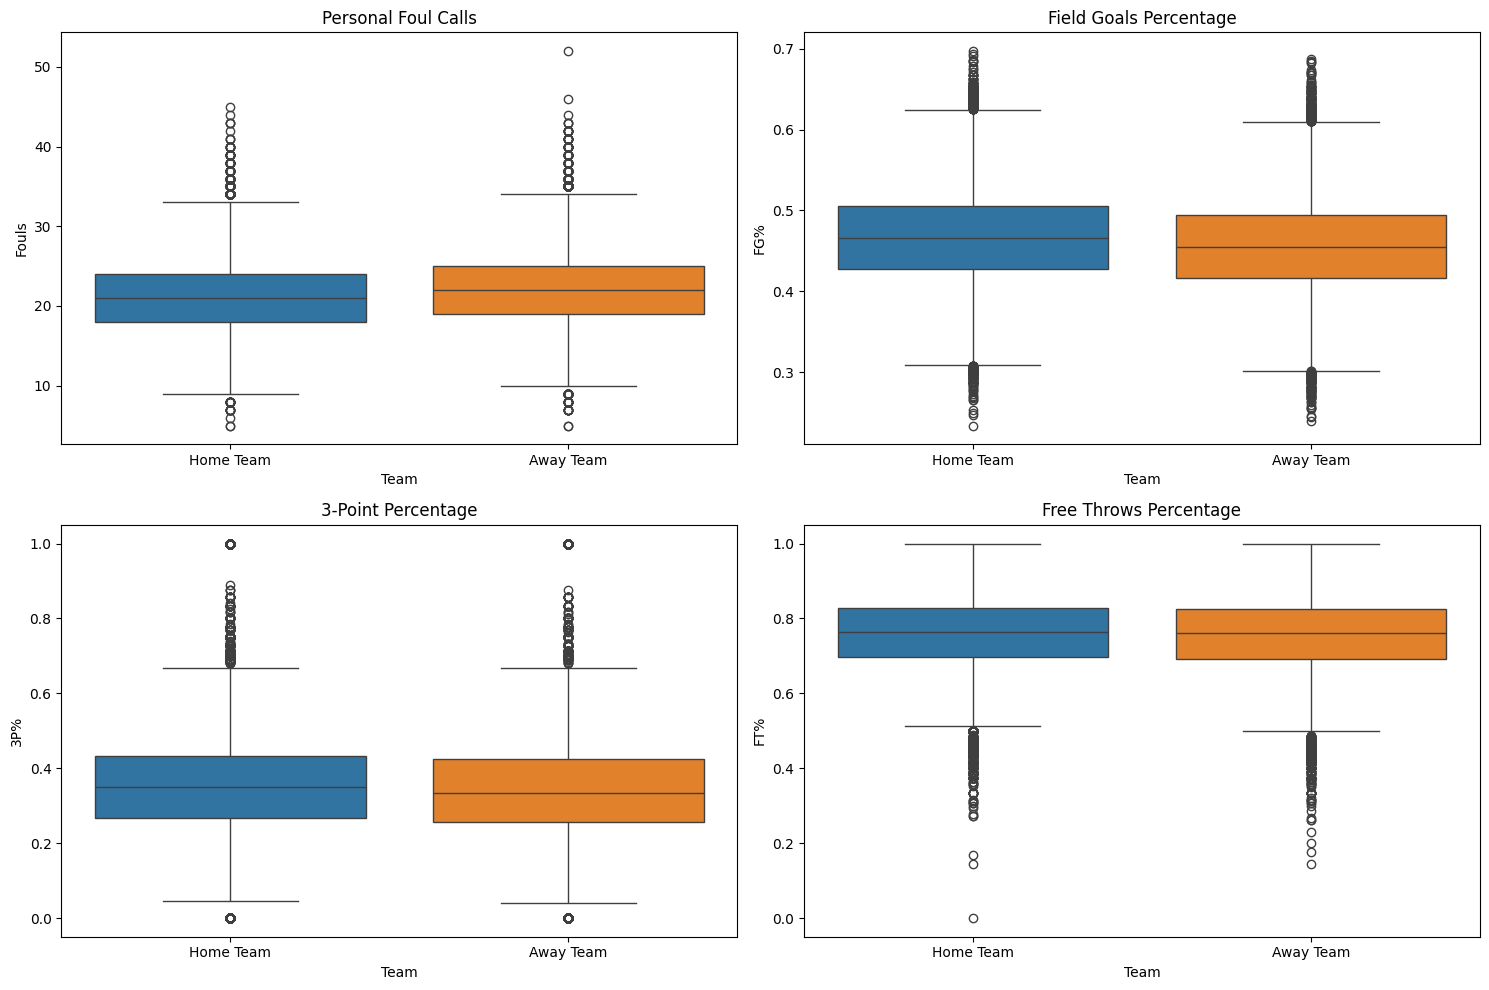

In [92]:
# Box Plots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

# Foul Calls
foul_data = pd.DataFrame({
    "Foul Count": pd.concat([home_statistics_df["foulsPersonal"], away_statistics_df["foulsPersonal"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["foulsPersonal"]) + ["Away Team"] * len(away_statistics_df["foulsPersonal"])
})

sns.boxplot(data=foul_data, x="Team", y="Foul Count", hue="Team", ax=ax[0])
ax[0].set_title("Personal Foul Calls")
ax[0].set_ylabel("Fouls")

# FG%
fg_data = pd.DataFrame({
    "FG%": pd.concat([home_statistics_df["fieldGoalsPercentage"], away_statistics_df["fieldGoalsPercentage"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["fieldGoalsPercentage"]) + ["Away Team"] * len(away_statistics_df["fieldGoalsPercentage"])
})

sns.boxplot(data=fg_data, x="Team", y="FG%", hue="Team", ax=ax[1])
ax[1].set_title("Field Goals Percentage")
ax[1].set_ylabel("FG%")

# 3P%
three_data = pd.DataFrame({
    "3P%": pd.concat([home_statistics_df["threePointersPercentage"], away_statistics_df["threePointersPercentage"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["threePointersPercentage"]) + ["Away Team"] * len(away_statistics_df["threePointersPercentage"])
})

sns.boxplot(data=three_data, x="Team", y="3P%", hue="Team", ax=ax[2])
ax[2].set_title("3-Point Percentage")
ax[2].set_ylabel("3P%")

# FT%
ft_data = pd.DataFrame({
    "FT%": pd.concat([home_statistics_df["freeThrowsPercentage"], away_statistics_df["freeThrowsPercentage"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["freeThrowsPercentage"]) + ["Away Team"] * len(away_statistics_df["freeThrowsPercentage"])
})

sns.boxplot(data=ft_data, x="Team", y="FT%", hue="Team", ax=ax[3])
ax[3].set_title("Free Throws Percentage")
ax[3].set_ylabel("FT%")


plt.tight_layout()
plt.show()

## Does the home team win more often than the away team?

To compare whether the home team wins more often than the away team, we will perform a Proportions Test. This test will help us determine if there is a significant difference in win rates between home and away teams. For this, we want to check whether the two populations - home and away teams - differ significantly with respect to their win rates.

To be able to perform such a test, we need to check its assumptions:
- The two samples are independent: Because in the original data, we have two rows per game (one for home / away team, respectively), this condition is not met. To fix this, we simply only take the home team entries.
- Binary outcome: The outcome variable is binary (win or lose).
- Binomial Distribution: The outcome variable is binomially distributed. This condition is met, because we have two possible outcomes (win or lose).

Our Hypothesis is the following:
- Null Hypothesis (H0): The home team does not win more often than the away team (p_home = p_away)
- Alternative Hypothesis (H1): The home team wins more often than the away team (p_home > p_away)


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Calculate win and losses
total_games = len(home_statistics_df)
home_wins = home_statistics_df["win"].sum()
home_losses = total_games - home_wins

In [ ]:
# Perform test
h0 = 0.5
statistic, p_value = proportions_ztest(count=home_wins, nobs=total_games, value=h0, alternative="larger")
print(f"Z-statistic: {statistic}, p-value: {p_value}")

Z-statistic: 42.41894190351562, p-value: 0.0


We have a p-value of 0.0, which is less than the significance level of 0.05. Therefore, we reject the null hypothesis and conclude that the home team does indeed win more often than the away team.

## Does home team get more Fouls?

We use a similar approach as for the previous question. First generaly investigate if the home team has a higher proportion of fouls than when away. But here we want to compare the mean of the two distributions (home and away). For this reason we plan to apply a t-test.

First check if the assumptions hold
- normality (normal distributed)
- similar variance
- independent

For the same reason as above, we can already assume that they are independent.

Before we begin, let's create proper df's for this task

In [93]:
# how the data looks like
print(home_statistics_df["foulsPersonal"].describe())

# split into home and away
home_fouls_df = home_statistics_df["foulsPersonal"]
away_fouls_df = away_statistics_df["foulsPersonal"]

count    45542.000000
mean        21.179988
std          4.611438
min          5.000000
25%         18.000000
50%         21.000000
75%         24.000000
max         45.000000
Name: foulsPersonal, dtype: float64


And do the same EDA as before.

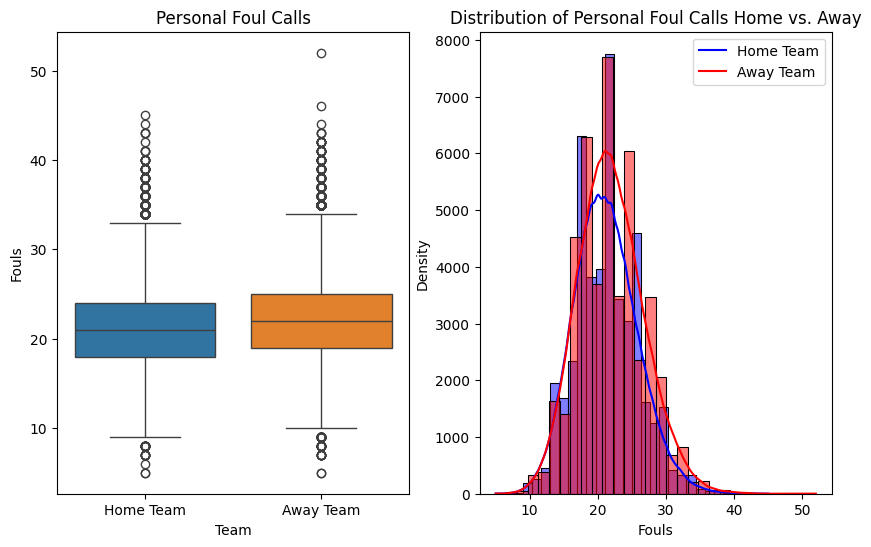

In [94]:
# same as above
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Foul Calls - boxplot
foul_data = pd.DataFrame({
    "Foul Count": pd.concat([home_statistics_df["foulsPersonal"], away_statistics_df["foulsPersonal"]], axis=0),
    "Team": ["Home Team"] * len(home_statistics_df["foulsPersonal"]) + ["Away Team"] * len(away_statistics_df["foulsPersonal"])
})

sns.boxplot(data=foul_data, x="Team", y="Foul Count", hue="Team", ax=axs[0])
axs[0].set_title("Personal Foul Calls")
axs[0].set_ylabel("Fouls")

# Foul Calls - histogram
sns.histplot(home_statistics_df["foulsPersonal"], bins=30, kde=True, color="blue", ax=axs[1])
sns.histplot(away_statistics_df["foulsPersonal"], bins=30, kde=True, color="red", ax=axs[1])
axs[1].set_title("Distribution of Personal Foul Calls Home vs. Away")
axs[1].set_xlabel("Fouls")
axs[1].set_ylabel("Density")
axs[1].legend(["Home Team", "Away Team"])

Check normality assumption with qq plot

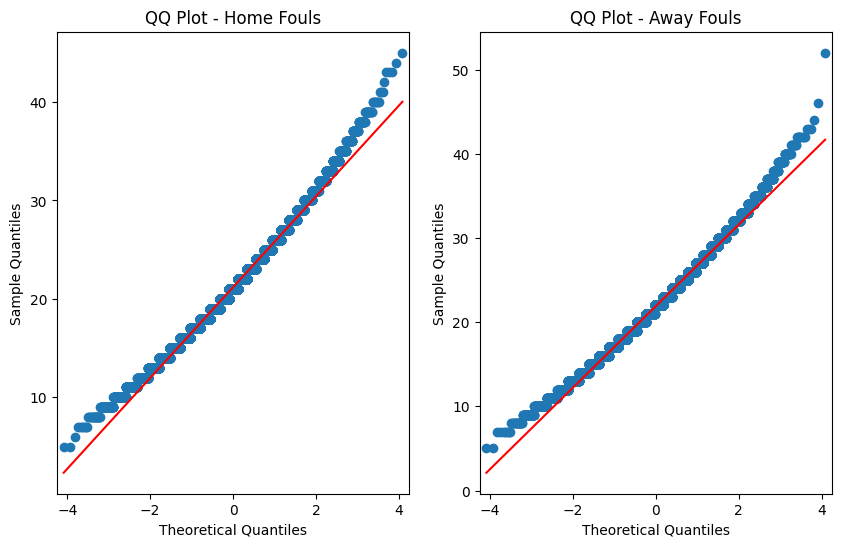

In [95]:
from statsmodels.graphics.gofplots import qqplot

def fouls_qqplot(home_df, away_df):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    # qq plot for home games
    qqplot(home_df, line="s", ax=axs[0])
    axs[0].set_title("QQ Plot - Home Fouls")

    # qq plot for away games
    qqplot(away_df, line="s", ax=axs[1])
    axs[1].set_title("QQ Plot - Away Fouls")

    plt.show()

fouls_qqplot(home_fouls_df, away_fouls_df)

This looks fairly normal distributed. We thus assume it is.

Now check if variance is similar. for this we take the ratio of the variances.

In [97]:
print(f"Variance ratio: {np.var(home_fouls_df) / np.var(away_fouls_df):.2f}")

Variance ratio: 0.91


variance is less than 4, so we can assume it's approximately equal (https://www.statology.org/t-test-assumptions/)

All assumptions are met. Thus we can continue with the t-test.